# Capstone 2: Modeling

### 1. Sourcing and Loading

#### 1a. Import Relevant Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

from library.sb_utils import save_file

#### 1b. Load the Data

In [2]:
import hickle as hkl

In [12]:
data = hkl.load("stroke_traintest_data.hkl")

In [11]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [13]:
# make sure the X data looks correct
X_train.head()

,gender,ever_married,Residence_type,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,id,hypertension,heart_disease,avg_glucose_level,bmi
2331,1,1,0,0,0,1,0,0,0,1,0,0,15351,0,0,-0.319417,0.459262
3901,1,1,1,0,0,1,0,0,0,0,1,0,37479,0,0,-0.269068,0.576150
1436,1,1,0,1,0,0,0,0,0,1,0,0,71318,0,0,3.050422,0.069636
1018,0,1,0,0,0,0,1,0,1,0,0,0,17437,0,0,-0.453680,-0.384927
3567,0,1,0,0,0,0,1,0,0,0,1,0,62475,1,0,-0.396707,0.602125


In [14]:
# make sure the y data is there
y_train.head()

2331    0
3901    0
1436    0
1018    0
3567    0
Name: stroke, dtype: int64

In [15]:
# verify data set shapes
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (4086, 17)
X_test shape: (1022, 17)
y_train shape: (4086,)
y_test shape: (1022,)


### 2. Create Baseline Models

Now, we can select a few algorithms and create baseline models. In these models, we want to keep things fairly simple and strive to select one or two algorithms to move forward with. Once we select the best models, we can do further parameter testing and try to optimize the performance. Speaking of performance, we will look at the ROC curves for the baseline models to determine their performace. Furthermore, reducing false-negative predictions (predicting non-stroke when actually stroke) is very important in healthcare datasets such as these where the predictions could lead to missing a diagnosis. 

The models that will be tested here are a random forest classifier, support vector machine, logistic regression, XGBoost, and CatBoost.

#### 2a. Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

In [44]:
# create grid search and fit model
params = {'n_estimators':[50, 100, 200, 300], 'max_depth':[3,7,20], 'min_samples_split':[2,4,10]}
rfc = RandomForestClassifier()
rfc_cv = GridSearchCV(rfc, params, scoring='recall', cv=5)
rfc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 7, 20],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='recall')

In [45]:
# print best parameters
print("Best Parameters: " + str(rfc_cv.best_params_))

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}


In [46]:
# create model with best parameters
rfc = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=50)
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

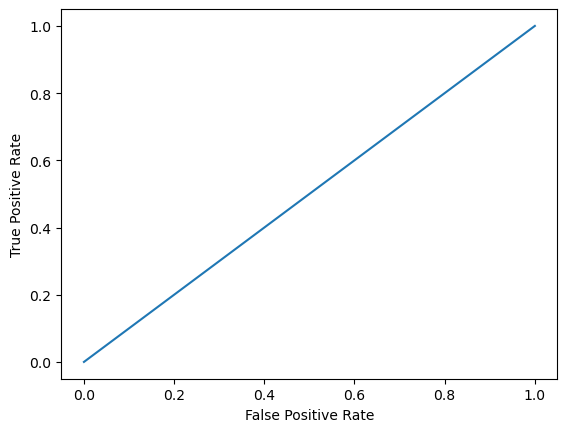

AUC score: 0.5


In [47]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [48]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)

As we can see from the ROC curve and the confusion matrix, this classifier did a bad job at distinguishing the classes. This model has zero recall, meaning it predicted all observations to be '0'.

#### 2b. Support Vector Machine

In [49]:
from sklearn.svm import SVC

In [50]:
# create grid search and fit model
params = {'C':[0.1, 1, 10, 100, 1000], 'gamma':['auto'], 'kernel':['rbf']}
svc = SVC()
svc_cv = GridSearchCV(svc, params, scoring='recall', cv=5)
svc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': ['auto'],
                         'kernel': ['rbf']},
             scoring='recall')

In [51]:
# print best parameters
print("Best Parameters: " + str(svc_cv.best_params_))

Best Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}


In [52]:
# create model with best parameters
svc = SVC(C=0.1, gamma='auto', kernel='rbf')
svc.fit(X_train, y_train)
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

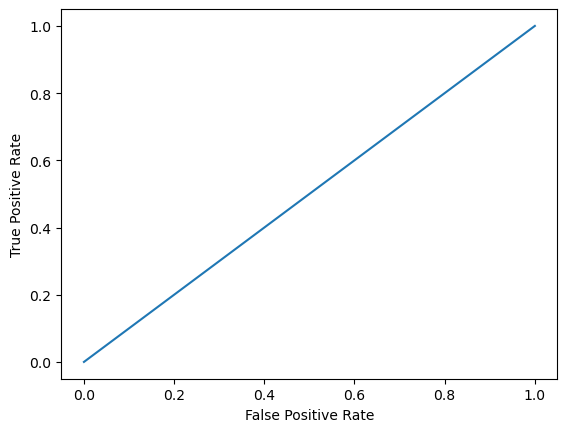

AUC score: 0.5


In [53]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [54]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)

The same thing happened again: all 62 stroke events were predicted to be non-strokes. This is a problem and a useless model for our goal. We will keep trying to find another model that can distinguish the two classes.

#### 2c. Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression

In [57]:
# create grid search and fit model
params = {'penalty':['none', 'l1', 'l2'], 'C':[0.1, 1, 10, 100, 1000]}
logr = LogisticRegression()
logr_cv = GridSearchCV(logr, params, scoring='recall', cv=5)
logr_cv.fit(X_train,y_train)

C:\Users\tscofield\Documents\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\tscofield\Documents\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\tscofield\Documents\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\tscofield\Documents\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\tscofield\Documents\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\tscofield\Documents\Anaconda\lib\sit

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'penalty': ['none', 'l1', 'l2']},
             scoring='recall')

In [58]:
# print best parameters
print("Best Parameters: " + str(logr_cv.best_params_))

Best Parameters: {'C': 0.1, 'penalty': 'none'}


In [59]:
# create model with best parameters
logr = LogisticRegression(C=0.1, penalty='none')
logr.fit(X_train, y_train)
y_train_pred = logr.predict(X_train)
y_test_pred = logr.predict(X_test)

C:\Users\tscofield\Documents\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


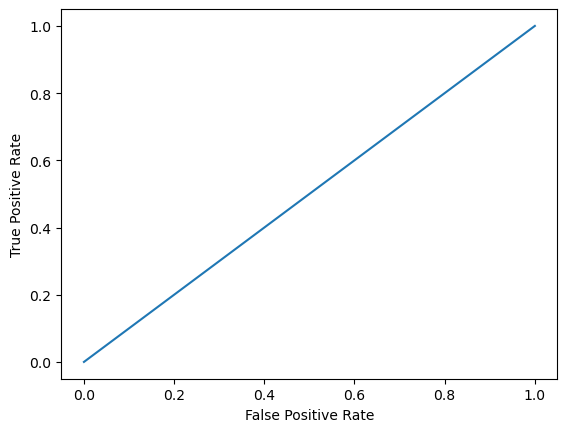

AUC score: 0.5


In [60]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [61]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)

Same results...

#### 2d. XGBoost

In [65]:
! pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 1.7 MB/s eta 0:00:00


In [66]:
from xgboost import XGBClassifier

In [67]:
# train general XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [68]:
# predict on training and testing sets
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

y_train_pred = [round(value) for value in y_train_pred]
y_test_pred = [round(value) for value in y_test_pred]

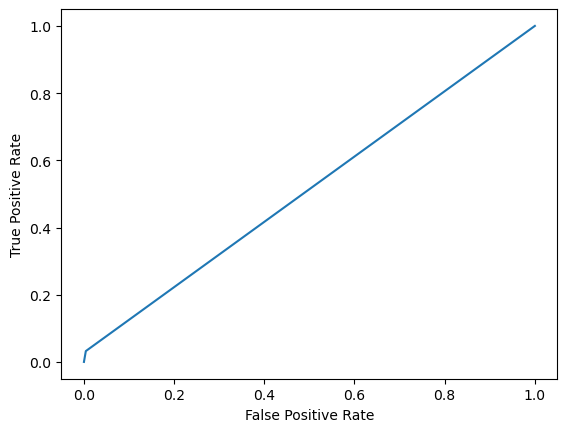

AUC score: 0.5140456989247312


In [69]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [70]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[956,   4],
       [ 60,   2]], dtype=int64)

This model predicted 2 stroke victims correctly, and predicted 4 incorrectly. This is better than a recall of zero but needs much improvement to be a sensible model.

#### 2e. CatBoost

In [71]:
! pip install catboost

In [72]:
from catboost import CatBoostClassifier

In [73]:
# create grid search and fit model
params = {'depth':[4,6,8,10], 'learning_rate':[0.01, 0.05, 0.1], 'iterations':[10, 50, 100]}
cbc = CatBoostClassifier()
cbc_cv = GridSearchCV(cbc, params, scoring='recall', cv=5)
cbc_cv.fit(X_train,y_train)

0:	learn: 0.6851239	total: 200ms	remaining: 1.8s
1:	learn: 0.6772281	total: 202ms	remaining: 808ms
2:	learn: 0.6695828	total: 203ms	remaining: 474ms
3:	learn: 0.6620931	total: 205ms	remaining: 307ms
4:	learn: 0.6546041	total: 207ms	remaining: 207ms
5:	learn: 0.6473130	total: 208ms	remaining: 139ms
6:	learn: 0.6403384	total: 210ms	remaining: 89.8ms
7:	learn: 0.6333898	total: 211ms	remaining: 52.8ms
8:	learn: 0.6264499	total: 212ms	remaining: 23.6ms
9:	learn: 0.6197463	total: 214ms	remaining: 0us
0:	learn: 0.6851577	total: 2.06ms	remaining: 18.5ms
1:	learn: 0.6772867	total: 3.64ms	remaining: 14.6ms
2:	learn: 0.6696793	total: 5.08ms	remaining: 11.9ms
3:	learn: 0.6621962	total: 6.63ms	remaining: 9.95ms
4:	learn: 0.6547151	total: 8.09ms	remaining: 8.09ms
5:	learn: 0.6474312	total: 9.53ms	remaining: 6.35ms
6:	learn: 0.6404628	total: 11.2ms	remaining: 4.8ms
7:	learn: 0.6335239	total: 12.6ms	remaining: 3.16ms
8:	learn: 0.6266017	total: 14ms	remaining: 1.55ms
9:	learn: 0.6199017	total: 15.4ms	r

34:	learn: 0.4843709	total: 52.8ms	remaining: 22.6ms
35:	learn: 0.4799610	total: 55.2ms	remaining: 21.4ms
36:	learn: 0.4757946	total: 57ms	remaining: 20ms
37:	learn: 0.4716419	total: 58.7ms	remaining: 18.5ms
38:	learn: 0.4674890	total: 60.4ms	remaining: 17ms
39:	learn: 0.4634348	total: 62.1ms	remaining: 15.5ms
40:	learn: 0.4594061	total: 64ms	remaining: 14ms
41:	learn: 0.4554945	total: 65.6ms	remaining: 12.5ms
42:	learn: 0.4516169	total: 67.1ms	remaining: 10.9ms
43:	learn: 0.4477814	total: 68.5ms	remaining: 9.35ms
44:	learn: 0.4439682	total: 70ms	remaining: 7.78ms
45:	learn: 0.4403135	total: 72.3ms	remaining: 6.28ms
46:	learn: 0.4366687	total: 73.8ms	remaining: 4.71ms
47:	learn: 0.4330695	total: 75.4ms	remaining: 3.14ms
48:	learn: 0.4295010	total: 77.3ms	remaining: 1.58ms
49:	learn: 0.4260008	total: 78.9ms	remaining: 0us
0:	learn: 0.6851694	total: 1.55ms	remaining: 75.8ms
1:	learn: 0.6772891	total: 3.1ms	remaining: 74.3ms
2:	learn: 0.6696836	total: 4.61ms	remaining: 72.2ms
3:	learn: 0.

46:	learn: 0.4361542	total: 68ms	remaining: 4.34ms
47:	learn: 0.4325337	total: 70.6ms	remaining: 2.94ms
48:	learn: 0.4289537	total: 72.1ms	remaining: 1.47ms
49:	learn: 0.4254230	total: 73.6ms	remaining: 0us
0:	learn: 0.6538343	total: 1.55ms	remaining: 75.8ms
1:	learn: 0.6180682	total: 2.91ms	remaining: 69.9ms
2:	learn: 0.5859273	total: 4.28ms	remaining: 67ms
3:	learn: 0.5566011	total: 5.64ms	remaining: 64.8ms
4:	learn: 0.5292139	total: 6.95ms	remaining: 62.6ms
5:	learn: 0.5042831	total: 8.59ms	remaining: 63ms
6:	learn: 0.4819307	total: 10.1ms	remaining: 61.8ms
7:	learn: 0.4609733	total: 11.5ms	remaining: 60.5ms
8:	learn: 0.4412432	total: 13ms	remaining: 59ms
9:	learn: 0.4233192	total: 14.5ms	remaining: 57.8ms
10:	learn: 0.4064680	total: 15.8ms	remaining: 56ms
11:	learn: 0.3907371	total: 17.2ms	remaining: 54.4ms
12:	learn: 0.3765298	total: 18.6ms	remaining: 52.9ms
13:	learn: 0.3630228	total: 20ms	remaining: 51.4ms
14:	learn: 0.3502923	total: 20.9ms	remaining: 48.8ms
15:	learn: 0.3384122

0:	learn: 0.6538792	total: 3ms	remaining: 147ms
1:	learn: 0.6180872	total: 4.77ms	remaining: 114ms
2:	learn: 0.5859979	total: 6.24ms	remaining: 97.8ms
3:	learn: 0.5566338	total: 7.74ms	remaining: 89.1ms
4:	learn: 0.5292372	total: 9.3ms	remaining: 83.7ms
5:	learn: 0.5043195	total: 10.9ms	remaining: 79.9ms
6:	learn: 0.4819637	total: 12.5ms	remaining: 76.5ms
7:	learn: 0.4610016	total: 14ms	remaining: 73.6ms
8:	learn: 0.4412532	total: 16.1ms	remaining: 73.6ms
9:	learn: 0.4233481	total: 17.8ms	remaining: 71.1ms
10:	learn: 0.4065020	total: 19.4ms	remaining: 68.7ms
11:	learn: 0.3908049	total: 21ms	remaining: 66.5ms
12:	learn: 0.3765666	total: 23.3ms	remaining: 66.3ms
13:	learn: 0.3630883	total: 26.1ms	remaining: 67ms
14:	learn: 0.3506394	total: 27.6ms	remaining: 64.4ms
15:	learn: 0.3392636	total: 29.1ms	remaining: 61.7ms
16:	learn: 0.3283034	total: 31.9ms	remaining: 61.9ms
17:	learn: 0.3179588	total: 33.4ms	remaining: 59.4ms
18:	learn: 0.3084568	total: 34.8ms	remaining: 56.7ms
19:	learn: 0.29

41:	learn: 0.1687947	total: 63.9ms	remaining: 12.2ms
42:	learn: 0.1679773	total: 66.1ms	remaining: 10.8ms
43:	learn: 0.1674475	total: 67.7ms	remaining: 9.23ms
44:	learn: 0.1670638	total: 69.3ms	remaining: 7.7ms
45:	learn: 0.1664142	total: 70.9ms	remaining: 6.16ms
46:	learn: 0.1656972	total: 73ms	remaining: 4.66ms
47:	learn: 0.1653161	total: 74.4ms	remaining: 3.1ms
48:	learn: 0.1648027	total: 76.2ms	remaining: 1.55ms
49:	learn: 0.1644206	total: 77.8ms	remaining: 0us
0:	learn: 0.6165961	total: 1.69ms	remaining: 82.7ms
1:	learn: 0.5533421	total: 3.09ms	remaining: 74.3ms
2:	learn: 0.5013964	total: 4.49ms	remaining: 70.3ms
3:	learn: 0.4574816	total: 5.88ms	remaining: 67.6ms
4:	learn: 0.4194402	total: 7.27ms	remaining: 65.5ms
5:	learn: 0.3872386	total: 8.72ms	remaining: 64ms
6:	learn: 0.3602981	total: 10.1ms	remaining: 62.2ms
7:	learn: 0.3365829	total: 11.6ms	remaining: 60.7ms
8:	learn: 0.3155538	total: 13.9ms	remaining: 63.5ms
9:	learn: 0.2977810	total: 15.5ms	remaining: 62.2ms
10:	learn: 0

0:	learn: 0.6851577	total: 1.64ms	remaining: 163ms
1:	learn: 0.6772867	total: 3.37ms	remaining: 165ms
2:	learn: 0.6696793	total: 4.87ms	remaining: 157ms
3:	learn: 0.6621962	total: 8.07ms	remaining: 194ms
4:	learn: 0.6547151	total: 9.84ms	remaining: 187ms
5:	learn: 0.6474312	total: 11.3ms	remaining: 178ms
6:	learn: 0.6404628	total: 12.7ms	remaining: 169ms
7:	learn: 0.6335239	total: 14.2ms	remaining: 163ms
8:	learn: 0.6266017	total: 15.5ms	remaining: 157ms
9:	learn: 0.6199017	total: 16.9ms	remaining: 152ms
10:	learn: 0.6132741	total: 18.3ms	remaining: 148ms
11:	learn: 0.6068041	total: 19.7ms	remaining: 144ms
12:	learn: 0.6004832	total: 21.9ms	remaining: 147ms
13:	learn: 0.5942244	total: 23.8ms	remaining: 146ms
14:	learn: 0.5879305	total: 24.7ms	remaining: 140ms
15:	learn: 0.5818350	total: 26.1ms	remaining: 137ms
16:	learn: 0.5759149	total: 27.6ms	remaining: 135ms
17:	learn: 0.5701305	total: 29ms	remaining: 132ms
18:	learn: 0.5642604	total: 29.9ms	remaining: 127ms
19:	learn: 0.5586257	tot

0:	learn: 0.6851609	total: 1.57ms	remaining: 156ms
1:	learn: 0.6772819	total: 3.36ms	remaining: 165ms
2:	learn: 0.6696723	total: 5.07ms	remaining: 164ms
3:	learn: 0.6621884	total: 7.34ms	remaining: 176ms
4:	learn: 0.6547062	total: 9.17ms	remaining: 174ms
5:	learn: 0.6474309	total: 10.6ms	remaining: 166ms
6:	learn: 0.6404689	total: 12ms	remaining: 159ms
7:	learn: 0.6335293	total: 13.3ms	remaining: 153ms
8:	learn: 0.6265949	total: 14.6ms	remaining: 147ms
9:	learn: 0.6199085	total: 16ms	remaining: 144ms
10:	learn: 0.6132919	total: 17.3ms	remaining: 140ms
11:	learn: 0.6068174	total: 19.2ms	remaining: 141ms
12:	learn: 0.6004968	total: 20.6ms	remaining: 138ms
13:	learn: 0.5942412	total: 23ms	remaining: 141ms
14:	learn: 0.5879470	total: 24.1ms	remaining: 137ms
15:	learn: 0.5818497	total: 25.6ms	remaining: 134ms
16:	learn: 0.5759264	total: 27ms	remaining: 132ms
17:	learn: 0.5701441	total: 28.4ms	remaining: 130ms
18:	learn: 0.5642732	total: 29.2ms	remaining: 125ms
19:	learn: 0.5586368	total: 30

0:	learn: 0.6538343	total: 2.1ms	remaining: 208ms
1:	learn: 0.6180682	total: 3.96ms	remaining: 194ms
2:	learn: 0.5859273	total: 5.45ms	remaining: 176ms
3:	learn: 0.5566011	total: 7.09ms	remaining: 170ms
4:	learn: 0.5292139	total: 8.68ms	remaining: 165ms
5:	learn: 0.5042831	total: 12.7ms	remaining: 199ms
6:	learn: 0.4819307	total: 14.3ms	remaining: 190ms
7:	learn: 0.4609733	total: 16.3ms	remaining: 188ms
8:	learn: 0.4412432	total: 17.7ms	remaining: 179ms
9:	learn: 0.4233192	total: 19.2ms	remaining: 173ms
10:	learn: 0.4064680	total: 20.6ms	remaining: 167ms
11:	learn: 0.3907371	total: 22ms	remaining: 161ms
12:	learn: 0.3765298	total: 23.5ms	remaining: 157ms
13:	learn: 0.3630228	total: 25ms	remaining: 153ms
14:	learn: 0.3502923	total: 27.3ms	remaining: 155ms
15:	learn: 0.3384122	total: 28.9ms	remaining: 152ms
16:	learn: 0.3276172	total: 30.5ms	remaining: 149ms
17:	learn: 0.3177438	total: 31.9ms	remaining: 145ms
18:	learn: 0.3081044	total: 33.2ms	remaining: 142ms
19:	learn: 0.2994219	total:

0:	learn: 0.6540449	total: 1.57ms	remaining: 156ms
1:	learn: 0.6187904	total: 3.55ms	remaining: 174ms
2:	learn: 0.5867735	total: 5.9ms	remaining: 191ms
3:	learn: 0.5574262	total: 7.45ms	remaining: 179ms
4:	learn: 0.5300403	total: 8.78ms	remaining: 167ms
5:	learn: 0.5051367	total: 10.3ms	remaining: 162ms
6:	learn: 0.4827965	total: 11.7ms	remaining: 155ms
7:	learn: 0.4618586	total: 13ms	remaining: 150ms
8:	learn: 0.4421389	total: 14.3ms	remaining: 145ms
9:	learn: 0.4242437	total: 15.7ms	remaining: 142ms
10:	learn: 0.4074503	total: 17.6ms	remaining: 142ms
11:	learn: 0.3917534	total: 19ms	remaining: 139ms
12:	learn: 0.3775512	total: 20.6ms	remaining: 138ms
13:	learn: 0.3641470	total: 22ms	remaining: 135ms
14:	learn: 0.3514330	total: 22.8ms	remaining: 129ms
15:	learn: 0.3395410	total: 24.2ms	remaining: 127ms
16:	learn: 0.3288731	total: 25.6ms	remaining: 125ms
17:	learn: 0.3189970	total: 26.9ms	remaining: 123ms
18:	learn: 0.3095665	total: 28.3ms	remaining: 121ms
19:	learn: 0.3009020	total: 2

0:	learn: 0.6538792	total: 5.45ms	remaining: 540ms
1:	learn: 0.6180872	total: 7.28ms	remaining: 357ms
2:	learn: 0.5859979	total: 8.92ms	remaining: 289ms
3:	learn: 0.5566338	total: 10.4ms	remaining: 250ms
4:	learn: 0.5292372	total: 11.9ms	remaining: 226ms
5:	learn: 0.5043195	total: 13.3ms	remaining: 208ms
6:	learn: 0.4819637	total: 14.7ms	remaining: 195ms
7:	learn: 0.4610016	total: 16.5ms	remaining: 190ms
8:	learn: 0.4412532	total: 18.2ms	remaining: 184ms
9:	learn: 0.4233481	total: 20.8ms	remaining: 187ms
10:	learn: 0.4065020	total: 22.5ms	remaining: 182ms
11:	learn: 0.3908049	total: 23.9ms	remaining: 175ms
12:	learn: 0.3765666	total: 25.3ms	remaining: 169ms
13:	learn: 0.3630883	total: 26.6ms	remaining: 163ms
14:	learn: 0.3506394	total: 27.9ms	remaining: 158ms
15:	learn: 0.3392636	total: 29.4ms	remaining: 154ms
16:	learn: 0.3283034	total: 30.9ms	remaining: 151ms
17:	learn: 0.3179588	total: 32.4ms	remaining: 147ms
18:	learn: 0.3084568	total: 34.4ms	remaining: 146ms
19:	learn: 0.2997353	t

0:	learn: 0.6168285	total: 1.61ms	remaining: 160ms
1:	learn: 0.5545687	total: 3.41ms	remaining: 167ms
2:	learn: 0.5026655	total: 5.08ms	remaining: 164ms
3:	learn: 0.4587610	total: 6.52ms	remaining: 157ms
4:	learn: 0.4207113	total: 8.66ms	remaining: 165ms
5:	learn: 0.3884504	total: 10.8ms	remaining: 168ms
6:	learn: 0.3614672	total: 12.2ms	remaining: 162ms
7:	learn: 0.3377652	total: 13.5ms	remaining: 156ms
8:	learn: 0.3170012	total: 14.9ms	remaining: 150ms
9:	learn: 0.2991087	total: 16.2ms	remaining: 146ms
10:	learn: 0.2830873	total: 17.6ms	remaining: 143ms
11:	learn: 0.2690392	total: 19.4ms	remaining: 142ms
12:	learn: 0.2574357	total: 20.9ms	remaining: 140ms
13:	learn: 0.2468781	total: 22.2ms	remaining: 136ms
14:	learn: 0.2376344	total: 24.3ms	remaining: 138ms
15:	learn: 0.2293506	total: 25.7ms	remaining: 135ms
16:	learn: 0.2222529	total: 27.1ms	remaining: 132ms
17:	learn: 0.2157684	total: 28.5ms	remaining: 130ms
18:	learn: 0.2102302	total: 29.8ms	remaining: 127ms
19:	learn: 0.2053482	t

0:	learn: 0.6168254	total: 1.98ms	remaining: 196ms
1:	learn: 0.5537470	total: 4.33ms	remaining: 212ms
2:	learn: 0.5019875	total: 5.78ms	remaining: 187ms
3:	learn: 0.4581499	total: 7.21ms	remaining: 173ms
4:	learn: 0.4201503	total: 8.83ms	remaining: 168ms
5:	learn: 0.3880177	total: 10.3ms	remaining: 161ms
6:	learn: 0.3611288	total: 11.7ms	remaining: 155ms
7:	learn: 0.3374638	total: 13.1ms	remaining: 151ms
8:	learn: 0.3164562	total: 14.6ms	remaining: 147ms
9:	learn: 0.2987534	total: 16.3ms	remaining: 146ms
10:	learn: 0.2828915	total: 17.8ms	remaining: 144ms
11:	learn: 0.2689637	total: 19.2ms	remaining: 140ms
12:	learn: 0.2574161	total: 20.7ms	remaining: 138ms
13:	learn: 0.2466313	total: 22.1ms	remaining: 136ms
14:	learn: 0.2375387	total: 23.8ms	remaining: 135ms
15:	learn: 0.2297303	total: 25.5ms	remaining: 134ms
16:	learn: 0.2225803	total: 27ms	remaining: 132ms
17:	learn: 0.2160680	total: 28.7ms	remaining: 131ms
18:	learn: 0.2106389	total: 30.3ms	remaining: 129ms
19:	learn: 0.2056944	tot

0:	learn: 0.6851239	total: 2.18ms	remaining: 19.7ms
1:	learn: 0.6779092	total: 5.4ms	remaining: 21.6ms
2:	learn: 0.6701407	total: 7.14ms	remaining: 16.7ms
3:	learn: 0.6630459	total: 9.72ms	remaining: 14.6ms
4:	learn: 0.6560879	total: 13ms	remaining: 13ms
5:	learn: 0.6489585	total: 17.5ms	remaining: 11.7ms
6:	learn: 0.6421253	total: 19.9ms	remaining: 8.51ms
7:	learn: 0.6353502	total: 22.1ms	remaining: 5.52ms
8:	learn: 0.6288566	total: 24.4ms	remaining: 2.72ms
9:	learn: 0.6223387	total: 26.7ms	remaining: 0us
0:	learn: 0.6851577	total: 2.09ms	remaining: 18.8ms
1:	learn: 0.6779678	total: 4.5ms	remaining: 18ms
2:	learn: 0.6702115	total: 5.88ms	remaining: 13.7ms
3:	learn: 0.6631038	total: 8.21ms	remaining: 12.3ms
4:	learn: 0.6561513	total: 10.7ms	remaining: 10.7ms
5:	learn: 0.6490468	total: 13.2ms	remaining: 8.78ms
6:	learn: 0.6421502	total: 15.5ms	remaining: 6.66ms
7:	learn: 0.6353892	total: 17.9ms	remaining: 4.46ms
8:	learn: 0.6289119	total: 20.2ms	remaining: 2.25ms
9:	learn: 0.6224301	tot

42:	learn: 0.4564977	total: 104ms	remaining: 17ms
43:	learn: 0.4525738	total: 107ms	remaining: 14.5ms
44:	learn: 0.4489181	total: 109ms	remaining: 12.1ms
45:	learn: 0.4452182	total: 111ms	remaining: 9.68ms
46:	learn: 0.4417031	total: 114ms	remaining: 7.27ms
47:	learn: 0.4383694	total: 118ms	remaining: 4.91ms
48:	learn: 0.4351646	total: 121ms	remaining: 2.47ms
49:	learn: 0.4314774	total: 122ms	remaining: 0us
0:	learn: 0.6851577	total: 2.21ms	remaining: 108ms
1:	learn: 0.6779678	total: 6.08ms	remaining: 146ms
2:	learn: 0.6702115	total: 7.5ms	remaining: 117ms
3:	learn: 0.6631038	total: 9.89ms	remaining: 114ms
4:	learn: 0.6561513	total: 12.6ms	remaining: 114ms
5:	learn: 0.6490468	total: 15ms	remaining: 110ms
6:	learn: 0.6421502	total: 17.4ms	remaining: 107ms
7:	learn: 0.6353892	total: 21.2ms	remaining: 111ms
8:	learn: 0.6289119	total: 23.6ms	remaining: 108ms
9:	learn: 0.6224301	total: 25.9ms	remaining: 104ms
10:	learn: 0.6161807	total: 28.7ms	remaining: 102ms
11:	learn: 0.6095794	total: 30

1:	learn: 0.6779432	total: 6.8ms	remaining: 163ms
2:	learn: 0.6701747	total: 9.34ms	remaining: 146ms
3:	learn: 0.6630671	total: 11.9ms	remaining: 137ms
4:	learn: 0.6561086	total: 14.6ms	remaining: 131ms
5:	learn: 0.6489931	total: 17.1ms	remaining: 126ms
6:	learn: 0.6421476	total: 23.3ms	remaining: 143ms
7:	learn: 0.6353596	total: 29.8ms	remaining: 157ms
8:	learn: 0.6288857	total: 35.3ms	remaining: 161ms
9:	learn: 0.6223821	total: 41.5ms	remaining: 166ms
10:	learn: 0.6159616	total: 47.7ms	remaining: 169ms
11:	learn: 0.6093529	total: 51.2ms	remaining: 162ms
12:	learn: 0.6032417	total: 56.4ms	remaining: 161ms
13:	learn: 0.5973028	total: 59.7ms	remaining: 153ms
14:	learn: 0.5915254	total: 63.9ms	remaining: 149ms
15:	learn: 0.5852650	total: 65.3ms	remaining: 139ms
16:	learn: 0.5792805	total: 69.7ms	remaining: 135ms
17:	learn: 0.5737787	total: 73ms	remaining: 130ms
18:	learn: 0.5680220	total: 76.7ms	remaining: 125ms
19:	learn: 0.5621832	total: 78.2ms	remaining: 117ms
20:	learn: 0.5565282	tot

2:	learn: 0.5885367	total: 9.47ms	remaining: 148ms
3:	learn: 0.5606278	total: 12.5ms	remaining: 144ms
4:	learn: 0.5349806	total: 15.3ms	remaining: 138ms
5:	learn: 0.5104014	total: 17.6ms	remaining: 129ms
6:	learn: 0.4879752	total: 20ms	remaining: 123ms
7:	learn: 0.4672133	total: 23.4ms	remaining: 123ms
8:	learn: 0.4485065	total: 26ms	remaining: 118ms
9:	learn: 0.4308039	total: 28.5ms	remaining: 114ms
10:	learn: 0.4142434	total: 31.3ms	remaining: 111ms
11:	learn: 0.3980993	total: 32.8ms	remaining: 104ms
12:	learn: 0.3840155	total: 35.5ms	remaining: 101ms
13:	learn: 0.3711798	total: 39.2ms	remaining: 101ms
14:	learn: 0.3593062	total: 41.8ms	remaining: 97.6ms
15:	learn: 0.3468900	total: 43.2ms	remaining: 91.7ms
16:	learn: 0.3356934	total: 45.8ms	remaining: 88.9ms
17:	learn: 0.3260438	total: 50.4ms	remaining: 89.6ms
18:	learn: 0.3162540	total: 53.4ms	remaining: 87.2ms
19:	learn: 0.3070355	total: 57.1ms	remaining: 85.7ms
20:	learn: 0.2988977	total: 59.8ms	remaining: 82.6ms
21:	learn: 0.2912

6:	learn: 0.3683863	total: 17.7ms	remaining: 109ms
7:	learn: 0.3443960	total: 21.2ms	remaining: 111ms
8:	learn: 0.3242809	total: 23.7ms	remaining: 108ms
9:	learn: 0.3057181	total: 26.1ms	remaining: 104ms
10:	learn: 0.2897204	total: 29ms	remaining: 103ms
11:	learn: 0.2750984	total: 30.8ms	remaining: 97.6ms
12:	learn: 0.2632265	total: 33.4ms	remaining: 95.1ms
13:	learn: 0.2530300	total: 36.6ms	remaining: 94ms
14:	learn: 0.2442993	total: 39.2ms	remaining: 91.6ms
15:	learn: 0.2353429	total: 40.3ms	remaining: 85.6ms
16:	learn: 0.2277260	total: 44.9ms	remaining: 87.2ms
17:	learn: 0.2213118	total: 47.3ms	remaining: 84.1ms
18:	learn: 0.2151208	total: 50.4ms	remaining: 82.2ms
19:	learn: 0.2094950	total: 53.2ms	remaining: 79.8ms
20:	learn: 0.2047571	total: 55.6ms	remaining: 76.8ms
21:	learn: 0.2002616	total: 56.8ms	remaining: 72.3ms
22:	learn: 0.1971149	total: 59.3ms	remaining: 69.6ms
23:	learn: 0.1935831	total: 61.6ms	remaining: 66.8ms
24:	learn: 0.1903120	total: 64ms	remaining: 64ms
25:	learn:

80:	learn: 0.3448762	total: 225ms	remaining: 52.9ms
81:	learn: 0.3426841	total: 228ms	remaining: 50.1ms
82:	learn: 0.3404585	total: 231ms	remaining: 47.2ms
83:	learn: 0.3382756	total: 233ms	remaining: 44.4ms
84:	learn: 0.3360981	total: 236ms	remaining: 41.6ms
85:	learn: 0.3340083	total: 240ms	remaining: 39.1ms
86:	learn: 0.3318886	total: 242ms	remaining: 36.2ms
87:	learn: 0.3299112	total: 245ms	remaining: 33.4ms
88:	learn: 0.3280170	total: 247ms	remaining: 30.6ms
89:	learn: 0.3261696	total: 251ms	remaining: 27.9ms
90:	learn: 0.3242383	total: 255ms	remaining: 25.3ms
91:	learn: 0.3223023	total: 258ms	remaining: 22.4ms
92:	learn: 0.3204038	total: 260ms	remaining: 19.6ms
93:	learn: 0.3184868	total: 262ms	remaining: 16.8ms
94:	learn: 0.3165799	total: 265ms	remaining: 13.9ms
95:	learn: 0.3147888	total: 267ms	remaining: 11.1ms
96:	learn: 0.3129384	total: 271ms	remaining: 8.39ms
97:	learn: 0.3110293	total: 273ms	remaining: 5.57ms
98:	learn: 0.3093804	total: 275ms	remaining: 2.78ms
99:	learn: 0

60:	learn: 0.3973167	total: 259ms	remaining: 165ms
61:	learn: 0.3943216	total: 264ms	remaining: 162ms
62:	learn: 0.3915551	total: 269ms	remaining: 158ms
63:	learn: 0.3886463	total: 273ms	remaining: 153ms
64:	learn: 0.3858848	total: 275ms	remaining: 148ms
65:	learn: 0.3830734	total: 281ms	remaining: 145ms
66:	learn: 0.3804179	total: 287ms	remaining: 141ms
67:	learn: 0.3777440	total: 290ms	remaining: 136ms
68:	learn: 0.3750346	total: 293ms	remaining: 131ms
69:	learn: 0.3724389	total: 299ms	remaining: 128ms
70:	learn: 0.3699154	total: 305ms	remaining: 124ms
71:	learn: 0.3673982	total: 307ms	remaining: 119ms
72:	learn: 0.3650263	total: 312ms	remaining: 115ms
73:	learn: 0.3625076	total: 314ms	remaining: 110ms
74:	learn: 0.3600264	total: 317ms	remaining: 106ms
75:	learn: 0.3577289	total: 319ms	remaining: 101ms
76:	learn: 0.3553988	total: 322ms	remaining: 96ms
77:	learn: 0.3531236	total: 325ms	remaining: 91.5ms
78:	learn: 0.3508221	total: 327ms	remaining: 87ms
79:	learn: 0.3485070	total: 330m

38:	learn: 0.4724148	total: 210ms	remaining: 328ms
39:	learn: 0.4683659	total: 220ms	remaining: 330ms
40:	learn: 0.4643838	total: 226ms	remaining: 325ms
41:	learn: 0.4605199	total: 237ms	remaining: 327ms
42:	learn: 0.4567429	total: 243ms	remaining: 322ms
43:	learn: 0.4531027	total: 254ms	remaining: 323ms
44:	learn: 0.4491780	total: 256ms	remaining: 313ms
45:	learn: 0.4454931	total: 270ms	remaining: 317ms
46:	learn: 0.4419909	total: 282ms	remaining: 318ms
47:	learn: 0.4386533	total: 291ms	remaining: 315ms
48:	learn: 0.4354434	total: 302ms	remaining: 315ms
49:	learn: 0.4317521	total: 304ms	remaining: 304ms
50:	learn: 0.4284313	total: 307ms	remaining: 295ms
51:	learn: 0.4250717	total: 314ms	remaining: 290ms
52:	learn: 0.4217136	total: 317ms	remaining: 281ms
53:	learn: 0.4183610	total: 327ms	remaining: 278ms
54:	learn: 0.4149676	total: 330ms	remaining: 270ms
55:	learn: 0.4118512	total: 333ms	remaining: 261ms
56:	learn: 0.4086748	total: 339ms	remaining: 256ms
57:	learn: 0.4055178	total: 344

37:	learn: 0.2132370	total: 90.4ms	remaining: 148ms
38:	learn: 0.2104128	total: 95.4ms	remaining: 149ms
39:	learn: 0.2076537	total: 98ms	remaining: 147ms
40:	learn: 0.2054462	total: 101ms	remaining: 146ms
41:	learn: 0.2031804	total: 104ms	remaining: 143ms
42:	learn: 0.2010585	total: 107ms	remaining: 141ms
43:	learn: 0.1992349	total: 109ms	remaining: 139ms
44:	learn: 0.1971015	total: 112ms	remaining: 136ms
45:	learn: 0.1952995	total: 115ms	remaining: 135ms
46:	learn: 0.1933045	total: 118ms	remaining: 133ms
47:	learn: 0.1918158	total: 122ms	remaining: 132ms
48:	learn: 0.1904133	total: 124ms	remaining: 129ms
49:	learn: 0.1892840	total: 127ms	remaining: 127ms
50:	learn: 0.1878323	total: 129ms	remaining: 124ms
51:	learn: 0.1866086	total: 131ms	remaining: 121ms
52:	learn: 0.1852523	total: 134ms	remaining: 119ms
53:	learn: 0.1839956	total: 136ms	remaining: 116ms
54:	learn: 0.1826377	total: 139ms	remaining: 113ms
55:	learn: 0.1816586	total: 141ms	remaining: 111ms
56:	learn: 0.1806058	total: 14

21:	learn: 0.2912634	total: 54.6ms	remaining: 194ms
22:	learn: 0.2845173	total: 58.8ms	remaining: 197ms
23:	learn: 0.2774937	total: 61.4ms	remaining: 194ms
24:	learn: 0.2711066	total: 64ms	remaining: 192ms
25:	learn: 0.2652523	total: 67.5ms	remaining: 192ms
26:	learn: 0.2595036	total: 70.7ms	remaining: 191ms
27:	learn: 0.2540457	total: 74.7ms	remaining: 192ms
28:	learn: 0.2494630	total: 78.2ms	remaining: 191ms
29:	learn: 0.2445426	total: 81.7ms	remaining: 191ms
30:	learn: 0.2401822	total: 84.9ms	remaining: 189ms
31:	learn: 0.2362863	total: 88.1ms	remaining: 187ms
32:	learn: 0.2321248	total: 93.6ms	remaining: 190ms
33:	learn: 0.2282313	total: 96.8ms	remaining: 188ms
34:	learn: 0.2246793	total: 100ms	remaining: 186ms
35:	learn: 0.2213421	total: 104ms	remaining: 184ms
36:	learn: 0.2186742	total: 106ms	remaining: 181ms
37:	learn: 0.2157173	total: 109ms	remaining: 177ms
38:	learn: 0.2131008	total: 112ms	remaining: 175ms
39:	learn: 0.2103527	total: 114ms	remaining: 171ms
40:	learn: 0.2078426

87:	learn: 0.1606933	total: 291ms	remaining: 39.6ms
88:	learn: 0.1603785	total: 296ms	remaining: 36.6ms
89:	learn: 0.1600260	total: 298ms	remaining: 33.2ms
90:	learn: 0.1596034	total: 304ms	remaining: 30.1ms
91:	learn: 0.1592419	total: 307ms	remaining: 26.7ms
92:	learn: 0.1589290	total: 309ms	remaining: 23.3ms
93:	learn: 0.1585479	total: 312ms	remaining: 19.9ms
94:	learn: 0.1581811	total: 315ms	remaining: 16.6ms
95:	learn: 0.1578929	total: 322ms	remaining: 13.4ms
96:	learn: 0.1576181	total: 324ms	remaining: 10ms
97:	learn: 0.1572770	total: 328ms	remaining: 6.7ms
98:	learn: 0.1569186	total: 336ms	remaining: 3.4ms
99:	learn: 0.1563811	total: 342ms	remaining: 0us
0:	learn: 0.6165145	total: 2.21ms	remaining: 219ms
1:	learn: 0.5573977	total: 11.9ms	remaining: 581ms
2:	learn: 0.5039124	total: 14ms	remaining: 453ms
3:	learn: 0.4620995	total: 16.4ms	remaining: 393ms
4:	learn: 0.4262380	total: 22.2ms	remaining: 422ms
5:	learn: 0.3936397	total: 27.4ms	remaining: 429ms
6:	learn: 0.3665734	total: 

82:	learn: 0.1413034	total: 285ms	remaining: 58.4ms
83:	learn: 0.1408535	total: 288ms	remaining: 54.8ms
84:	learn: 0.1404826	total: 291ms	remaining: 51.4ms
85:	learn: 0.1401695	total: 294ms	remaining: 47.8ms
86:	learn: 0.1399664	total: 297ms	remaining: 44.3ms
87:	learn: 0.1396793	total: 299ms	remaining: 40.8ms
88:	learn: 0.1391250	total: 302ms	remaining: 37.3ms
89:	learn: 0.1388401	total: 304ms	remaining: 33.8ms
90:	learn: 0.1383387	total: 308ms	remaining: 30.5ms
91:	learn: 0.1380849	total: 311ms	remaining: 27ms
92:	learn: 0.1377551	total: 314ms	remaining: 23.6ms
93:	learn: 0.1374958	total: 319ms	remaining: 20.4ms
94:	learn: 0.1371439	total: 324ms	remaining: 17ms
95:	learn: 0.1370005	total: 326ms	remaining: 13.6ms
96:	learn: 0.1365228	total: 329ms	remaining: 10.2ms
97:	learn: 0.1363369	total: 332ms	remaining: 6.77ms
98:	learn: 0.1360006	total: 334ms	remaining: 3.38ms
99:	learn: 0.1357854	total: 337ms	remaining: 0us
0:	learn: 0.6169196	total: 2.11ms	remaining: 209ms
1:	learn: 0.5593830	

45:	learn: 0.1614050	total: 123ms	remaining: 145ms
46:	learn: 0.1601528	total: 126ms	remaining: 142ms
47:	learn: 0.1594369	total: 129ms	remaining: 139ms
48:	learn: 0.1591760	total: 131ms	remaining: 136ms
49:	learn: 0.1586146	total: 134ms	remaining: 134ms
50:	learn: 0.1580341	total: 137ms	remaining: 132ms
51:	learn: 0.1572570	total: 140ms	remaining: 129ms
52:	learn: 0.1567521	total: 143ms	remaining: 127ms
53:	learn: 0.1562372	total: 145ms	remaining: 124ms
54:	learn: 0.1558388	total: 148ms	remaining: 121ms
55:	learn: 0.1555519	total: 152ms	remaining: 119ms
56:	learn: 0.1547546	total: 154ms	remaining: 116ms
57:	learn: 0.1541124	total: 160ms	remaining: 116ms
58:	learn: 0.1536624	total: 162ms	remaining: 113ms
59:	learn: 0.1532768	total: 165ms	remaining: 110ms
60:	learn: 0.1526911	total: 168ms	remaining: 108ms
61:	learn: 0.1520235	total: 171ms	remaining: 105ms
62:	learn: 0.1515547	total: 174ms	remaining: 102ms
63:	learn: 0.1510562	total: 176ms	remaining: 99ms
64:	learn: 0.1507426	total: 179m

6:	learn: 0.6418525	total: 28.6ms	remaining: 12.3ms
7:	learn: 0.6353541	total: 36.4ms	remaining: 9.1ms
8:	learn: 0.6287656	total: 40.2ms	remaining: 4.46ms
9:	learn: 0.6219310	total: 41.9ms	remaining: 0us
0:	learn: 0.6851609	total: 4.87ms	remaining: 43.8ms
1:	learn: 0.6785185	total: 10.6ms	remaining: 42.4ms
2:	learn: 0.6712916	total: 19.8ms	remaining: 46.1ms
3:	learn: 0.6638154	total: 21.8ms	remaining: 32.7ms
4:	learn: 0.6563824	total: 24ms	remaining: 24ms
5:	learn: 0.6489849	total: 25.2ms	remaining: 16.8ms
6:	learn: 0.6418494	total: 27.6ms	remaining: 11.8ms
7:	learn: 0.6353429	total: 36.7ms	remaining: 9.18ms
8:	learn: 0.6287476	total: 40.5ms	remaining: 4.5ms
9:	learn: 0.6219128	total: 43.4ms	remaining: 0us
0:	learn: 0.6851315	total: 2.06ms	remaining: 18.5ms
1:	learn: 0.6784710	total: 10.9ms	remaining: 43.4ms
2:	learn: 0.6712290	total: 16.6ms	remaining: 38.8ms
3:	learn: 0.6637395	total: 20.2ms	remaining: 30.3ms
4:	learn: 0.6562955	total: 22.5ms	remaining: 22.5ms
5:	learn: 0.6488856	tota

45:	learn: 0.4526227	total: 247ms	remaining: 21.5ms
46:	learn: 0.4491530	total: 250ms	remaining: 16ms
47:	learn: 0.4459341	total: 256ms	remaining: 10.7ms
48:	learn: 0.4420967	total: 258ms	remaining: 5.27ms
49:	learn: 0.4387422	total: 264ms	remaining: 0us
0:	learn: 0.6851577	total: 2.05ms	remaining: 100ms
1:	learn: 0.6785019	total: 8.02ms	remaining: 193ms
2:	learn: 0.6712693	total: 15ms	remaining: 235ms
3:	learn: 0.6637887	total: 16.8ms	remaining: 194ms
4:	learn: 0.6563522	total: 18.7ms	remaining: 168ms
5:	learn: 0.6489548	total: 20ms	remaining: 147ms
6:	learn: 0.6418231	total: 21.6ms	remaining: 133ms
7:	learn: 0.6353279	total: 26.7ms	remaining: 140ms
8:	learn: 0.6287290	total: 31.2ms	remaining: 142ms
9:	learn: 0.6218942	total: 32.6ms	remaining: 131ms
10:	learn: 0.6158343	total: 38ms	remaining: 135ms
11:	learn: 0.6100254	total: 44.7ms	remaining: 141ms
12:	learn: 0.6041232	total: 50ms	remaining: 142ms
13:	learn: 0.5980592	total: 54.9ms	remaining: 141ms
14:	learn: 0.5918172	total: 57ms	re

21:	learn: 0.5553735	total: 228ms	remaining: 290ms
22:	learn: 0.5501708	total: 237ms	remaining: 278ms
23:	learn: 0.5451446	total: 247ms	remaining: 267ms
24:	learn: 0.5405175	total: 260ms	remaining: 260ms
25:	learn: 0.5359016	total: 271ms	remaining: 250ms
26:	learn: 0.5313824	total: 288ms	remaining: 245ms
27:	learn: 0.5268080	total: 296ms	remaining: 233ms
28:	learn: 0.5219893	total: 310ms	remaining: 224ms
29:	learn: 0.5176213	total: 317ms	remaining: 212ms
30:	learn: 0.5133078	total: 326ms	remaining: 200ms
31:	learn: 0.5084136	total: 328ms	remaining: 184ms
32:	learn: 0.5041177	total: 342ms	remaining: 176ms
33:	learn: 0.4993725	total: 343ms	remaining: 162ms
34:	learn: 0.4949861	total: 358ms	remaining: 154ms
35:	learn: 0.4906531	total: 369ms	remaining: 144ms
36:	learn: 0.4865754	total: 376ms	remaining: 132ms
37:	learn: 0.4825692	total: 390ms	remaining: 123ms
38:	learn: 0.4783739	total: 394ms	remaining: 111ms
39:	learn: 0.4745783	total: 406ms	remaining: 101ms
40:	learn: 0.4702827	total: 407

33:	learn: 0.2304168	total: 209ms	remaining: 98.5ms
34:	learn: 0.2271995	total: 216ms	remaining: 92.8ms
35:	learn: 0.2238324	total: 222ms	remaining: 86.5ms
36:	learn: 0.2203269	total: 224ms	remaining: 78.7ms
37:	learn: 0.2171373	total: 231ms	remaining: 73.1ms
38:	learn: 0.2143167	total: 240ms	remaining: 67.7ms
39:	learn: 0.2118569	total: 248ms	remaining: 61.9ms
40:	learn: 0.2089316	total: 253ms	remaining: 55.5ms
41:	learn: 0.2066855	total: 258ms	remaining: 49.2ms
42:	learn: 0.2041843	total: 265ms	remaining: 43.1ms
43:	learn: 0.2019718	total: 270ms	remaining: 36.8ms
44:	learn: 0.1999385	total: 275ms	remaining: 30.6ms
45:	learn: 0.1980153	total: 282ms	remaining: 24.5ms
46:	learn: 0.1966432	total: 287ms	remaining: 18.3ms
47:	learn: 0.1950333	total: 293ms	remaining: 12.2ms
48:	learn: 0.1935561	total: 299ms	remaining: 6.1ms
49:	learn: 0.1920553	total: 304ms	remaining: 0us
0:	learn: 0.6540022	total: 2.31ms	remaining: 113ms
1:	learn: 0.6238420	total: 7.72ms	remaining: 185ms
2:	learn: 0.593017

12:	learn: 0.2641132	total: 67.7ms	remaining: 193ms
13:	learn: 0.2535029	total: 73.6ms	remaining: 189ms
14:	learn: 0.2442691	total: 80.2ms	remaining: 187ms
15:	learn: 0.2367044	total: 85.8ms	remaining: 182ms
16:	learn: 0.2282569	total: 88.7ms	remaining: 172ms
17:	learn: 0.2208985	total: 92.2ms	remaining: 164ms
18:	learn: 0.2151267	total: 102ms	remaining: 166ms
19:	learn: 0.2097440	total: 107ms	remaining: 160ms
20:	learn: 0.2058605	total: 115ms	remaining: 159ms
21:	learn: 0.2016797	total: 120ms	remaining: 153ms
22:	learn: 0.1979580	total: 126ms	remaining: 148ms
23:	learn: 0.1941338	total: 129ms	remaining: 140ms
24:	learn: 0.1906294	total: 131ms	remaining: 131ms
25:	learn: 0.1877444	total: 135ms	remaining: 125ms
26:	learn: 0.1851651	total: 141ms	remaining: 120ms
27:	learn: 0.1823086	total: 147ms	remaining: 115ms
28:	learn: 0.1799114	total: 152ms	remaining: 110ms
29:	learn: 0.1778145	total: 157ms	remaining: 105ms
30:	learn: 0.1757658	total: 162ms	remaining: 99.5ms
31:	learn: 0.1739606	tot

39:	learn: 0.1611109	total: 199ms	remaining: 49.9ms
40:	learn: 0.1605241	total: 207ms	remaining: 45.5ms
41:	learn: 0.1594206	total: 213ms	remaining: 40.6ms
42:	learn: 0.1583992	total: 219ms	remaining: 35.6ms
43:	learn: 0.1575407	total: 225ms	remaining: 30.7ms
44:	learn: 0.1568151	total: 234ms	remaining: 26ms
45:	learn: 0.1559668	total: 241ms	remaining: 20.9ms
46:	learn: 0.1550096	total: 246ms	remaining: 15.7ms
47:	learn: 0.1541341	total: 252ms	remaining: 10.5ms
48:	learn: 0.1531886	total: 258ms	remaining: 5.26ms
49:	learn: 0.1526020	total: 263ms	remaining: 0us
0:	learn: 0.6851239	total: 2.09ms	remaining: 207ms
1:	learn: 0.6784161	total: 8.89ms	remaining: 436ms
2:	learn: 0.6711477	total: 13.8ms	remaining: 448ms
3:	learn: 0.6636556	total: 16ms	remaining: 384ms
4:	learn: 0.6562146	total: 17.7ms	remaining: 337ms
5:	learn: 0.6488061	total: 19.2ms	remaining: 301ms
6:	learn: 0.6416604	total: 23ms	remaining: 306ms
7:	learn: 0.6351111	total: 27.9ms	remaining: 320ms
8:	learn: 0.6284988	total: 31

64:	learn: 0.3919526	total: 323ms	remaining: 174ms
65:	learn: 0.3892479	total: 329ms	remaining: 170ms
66:	learn: 0.3864770	total: 335ms	remaining: 165ms
67:	learn: 0.3836577	total: 337ms	remaining: 159ms
68:	learn: 0.3810315	total: 345ms	remaining: 155ms
69:	learn: 0.3782185	total: 348ms	remaining: 149ms
70:	learn: 0.3756200	total: 356ms	remaining: 145ms
71:	learn: 0.3732560	total: 362ms	remaining: 141ms
72:	learn: 0.3711277	total: 373ms	remaining: 138ms
73:	learn: 0.3684878	total: 376ms	remaining: 132ms
74:	learn: 0.3663134	total: 381ms	remaining: 127ms
75:	learn: 0.3638987	total: 387ms	remaining: 122ms
76:	learn: 0.3618060	total: 393ms	remaining: 117ms
77:	learn: 0.3592935	total: 395ms	remaining: 111ms
78:	learn: 0.3570490	total: 400ms	remaining: 106ms
79:	learn: 0.3548584	total: 407ms	remaining: 102ms
80:	learn: 0.3526099	total: 413ms	remaining: 96.8ms
81:	learn: 0.3503217	total: 415ms	remaining: 91.2ms
82:	learn: 0.3480882	total: 432ms	remaining: 88.4ms
83:	learn: 0.3458700	total: 

26:	learn: 0.5317902	total: 232ms	remaining: 628ms
27:	learn: 0.5272439	total: 244ms	remaining: 627ms
28:	learn: 0.5224533	total: 252ms	remaining: 618ms
29:	learn: 0.5181305	total: 265ms	remaining: 618ms
30:	learn: 0.5137781	total: 272ms	remaining: 605ms
31:	learn: 0.5088935	total: 276ms	remaining: 587ms
32:	learn: 0.5046145	total: 289ms	remaining: 588ms
33:	learn: 0.4998758	total: 293ms	remaining: 568ms
34:	learn: 0.4958507	total: 304ms	remaining: 564ms
35:	learn: 0.4915364	total: 310ms	remaining: 552ms
36:	learn: 0.4874628	total: 322ms	remaining: 549ms
37:	learn: 0.4834840	total: 330ms	remaining: 538ms
38:	learn: 0.4792792	total: 333ms	remaining: 521ms
39:	learn: 0.4754788	total: 347ms	remaining: 520ms
40:	learn: 0.4711866	total: 348ms	remaining: 501ms
41:	learn: 0.4674301	total: 359ms	remaining: 496ms
42:	learn: 0.4633311	total: 362ms	remaining: 480ms
43:	learn: 0.4593218	total: 364ms	remaining: 463ms
44:	learn: 0.4558950	total: 375ms	remaining: 459ms
45:	learn: 0.4522555	total: 381

94:	learn: 0.3220025	total: 399ms	remaining: 21ms
95:	learn: 0.3201375	total: 405ms	remaining: 16.9ms
96:	learn: 0.3185581	total: 411ms	remaining: 12.7ms
97:	learn: 0.3167608	total: 416ms	remaining: 8.5ms
98:	learn: 0.3150066	total: 422ms	remaining: 4.27ms
99:	learn: 0.3131398	total: 427ms	remaining: 0us
0:	learn: 0.6538343	total: 2.05ms	remaining: 203ms
1:	learn: 0.6233589	total: 7.92ms	remaining: 388ms
2:	learn: 0.5923561	total: 13.1ms	remaining: 423ms
3:	learn: 0.5625433	total: 14.9ms	remaining: 358ms
4:	learn: 0.5348918	total: 16.6ms	remaining: 316ms
5:	learn: 0.5091586	total: 17.8ms	remaining: 279ms
6:	learn: 0.4859263	total: 19.8ms	remaining: 262ms
7:	learn: 0.4658305	total: 24.8ms	remaining: 285ms
8:	learn: 0.4466624	total: 28.1ms	remaining: 284ms
9:	learn: 0.4293826	total: 33ms	remaining: 297ms
10:	learn: 0.4132617	total: 38.3ms	remaining: 310ms
11:	learn: 0.3980244	total: 43.3ms	remaining: 317ms
12:	learn: 0.3850676	total: 48.3ms	remaining: 323ms
13:	learn: 0.3717388	total: 53

68:	learn: 0.1706732	total: 347ms	remaining: 156ms
69:	learn: 0.1698475	total: 353ms	remaining: 151ms
70:	learn: 0.1690374	total: 358ms	remaining: 146ms
71:	learn: 0.1683321	total: 366ms	remaining: 142ms
72:	learn: 0.1674272	total: 372ms	remaining: 138ms
73:	learn: 0.1668359	total: 378ms	remaining: 133ms
74:	learn: 0.1662564	total: 383ms	remaining: 128ms
75:	learn: 0.1652443	total: 388ms	remaining: 123ms
76:	learn: 0.1646301	total: 394ms	remaining: 118ms
77:	learn: 0.1639585	total: 399ms	remaining: 113ms
78:	learn: 0.1633671	total: 404ms	remaining: 107ms
79:	learn: 0.1627578	total: 409ms	remaining: 102ms
80:	learn: 0.1621412	total: 414ms	remaining: 97.2ms
81:	learn: 0.1615442	total: 420ms	remaining: 92.1ms
82:	learn: 0.1610181	total: 425ms	remaining: 87ms
83:	learn: 0.1603673	total: 430ms	remaining: 81.8ms
84:	learn: 0.1597460	total: 435ms	remaining: 76.7ms
85:	learn: 0.1591988	total: 440ms	remaining: 71.6ms
86:	learn: 0.1587211	total: 445ms	remaining: 66.5ms
87:	learn: 0.1582649	total

33:	learn: 0.2304761	total: 204ms	remaining: 397ms
34:	learn: 0.2267235	total: 211ms	remaining: 392ms
35:	learn: 0.2234492	total: 219ms	remaining: 389ms
36:	learn: 0.2199866	total: 220ms	remaining: 375ms
37:	learn: 0.2170006	total: 227ms	remaining: 370ms
38:	learn: 0.2140514	total: 235ms	remaining: 367ms
39:	learn: 0.2115132	total: 245ms	remaining: 368ms
40:	learn: 0.2088985	total: 252ms	remaining: 363ms
41:	learn: 0.2064733	total: 260ms	remaining: 359ms
42:	learn: 0.2039445	total: 265ms	remaining: 351ms
43:	learn: 0.2017661	total: 272ms	remaining: 346ms
44:	learn: 0.1997439	total: 277ms	remaining: 339ms
45:	learn: 0.1980005	total: 282ms	remaining: 331ms
46:	learn: 0.1966060	total: 288ms	remaining: 325ms
47:	learn: 0.1948602	total: 294ms	remaining: 318ms
48:	learn: 0.1934334	total: 299ms	remaining: 311ms
49:	learn: 0.1918979	total: 305ms	remaining: 305ms
50:	learn: 0.1902257	total: 311ms	remaining: 299ms
51:	learn: 0.1888306	total: 316ms	remaining: 292ms
52:	learn: 0.1874118	total: 325

2:	learn: 0.5100112	total: 12.9ms	remaining: 417ms
3:	learn: 0.4647884	total: 16.2ms	remaining: 389ms
4:	learn: 0.4258465	total: 18.1ms	remaining: 344ms
5:	learn: 0.3921253	total: 19.3ms	remaining: 302ms
6:	learn: 0.3637682	total: 21.2ms	remaining: 282ms
7:	learn: 0.3407084	total: 26.8ms	remaining: 308ms
8:	learn: 0.3198561	total: 30.3ms	remaining: 307ms
9:	learn: 0.3017778	total: 35.8ms	remaining: 322ms
10:	learn: 0.2865910	total: 41.6ms	remaining: 337ms
11:	learn: 0.2724728	total: 48.1ms	remaining: 352ms
12:	learn: 0.2617363	total: 53.9ms	remaining: 360ms
13:	learn: 0.2506866	total: 58.8ms	remaining: 361ms
14:	learn: 0.2411841	total: 65.1ms	remaining: 369ms
15:	learn: 0.2335016	total: 70.1ms	remaining: 368ms
16:	learn: 0.2247057	total: 73.9ms	remaining: 361ms
17:	learn: 0.2173746	total: 76ms	remaining: 346ms
18:	learn: 0.2116601	total: 82.7ms	remaining: 353ms
19:	learn: 0.2065508	total: 89.7ms	remaining: 359ms
20:	learn: 0.2014833	total: 91.9ms	remaining: 346ms
21:	learn: 0.1971251	t

70:	learn: 0.1382847	total: 809ms	remaining: 330ms
71:	learn: 0.1376261	total: 823ms	remaining: 320ms
72:	learn: 0.1371785	total: 834ms	remaining: 308ms
73:	learn: 0.1366176	total: 848ms	remaining: 298ms
74:	learn: 0.1362556	total: 861ms	remaining: 287ms
75:	learn: 0.1354914	total: 882ms	remaining: 278ms
76:	learn: 0.1350002	total: 897ms	remaining: 268ms
77:	learn: 0.1343719	total: 912ms	remaining: 257ms
78:	learn: 0.1340818	total: 921ms	remaining: 245ms
79:	learn: 0.1334135	total: 932ms	remaining: 233ms
80:	learn: 0.1327473	total: 947ms	remaining: 222ms
81:	learn: 0.1322853	total: 962ms	remaining: 211ms
82:	learn: 0.1317268	total: 985ms	remaining: 202ms
83:	learn: 0.1312224	total: 995ms	remaining: 190ms
84:	learn: 0.1305712	total: 1.01s	remaining: 178ms
85:	learn: 0.1298801	total: 1.02s	remaining: 167ms
86:	learn: 0.1295054	total: 1.03s	remaining: 155ms
87:	learn: 0.1289975	total: 1.05s	remaining: 144ms
88:	learn: 0.1285573	total: 1.07s	remaining: 132ms
89:	learn: 0.1282034	total: 1.0

37:	learn: 0.1641794	total: 197ms	remaining: 322ms
38:	learn: 0.1631054	total: 207ms	remaining: 324ms
39:	learn: 0.1620264	total: 215ms	remaining: 323ms
40:	learn: 0.1607917	total: 221ms	remaining: 318ms
41:	learn: 0.1595917	total: 229ms	remaining: 317ms
42:	learn: 0.1589078	total: 237ms	remaining: 314ms
43:	learn: 0.1578613	total: 245ms	remaining: 312ms
44:	learn: 0.1568100	total: 251ms	remaining: 306ms
45:	learn: 0.1559357	total: 258ms	remaining: 303ms
46:	learn: 0.1547295	total: 264ms	remaining: 298ms
47:	learn: 0.1539308	total: 273ms	remaining: 296ms
48:	learn: 0.1528656	total: 280ms	remaining: 291ms
49:	learn: 0.1521534	total: 285ms	remaining: 285ms
50:	learn: 0.1510355	total: 294ms	remaining: 282ms
51:	learn: 0.1502177	total: 303ms	remaining: 280ms
52:	learn: 0.1491516	total: 311ms	remaining: 276ms
53:	learn: 0.1483028	total: 318ms	remaining: 271ms
54:	learn: 0.1476231	total: 326ms	remaining: 267ms
55:	learn: 0.1467232	total: 334ms	remaining: 262ms
56:	learn: 0.1461224	total: 342

0:	learn: 0.6851239	total: 1.68ms	remaining: 15.1ms
1:	learn: 0.6788892	total: 22.9ms	remaining: 91.6ms
2:	learn: 0.6714997	total: 27.3ms	remaining: 63.6ms
3:	learn: 0.6640153	total: 29.4ms	remaining: 44.1ms
4:	learn: 0.6578770	total: 47.9ms	remaining: 47.9ms
5:	learn: 0.6506987	total: 49.8ms	remaining: 33.2ms
6:	learn: 0.6450251	total: 67.9ms	remaining: 29.1ms
7:	learn: 0.6396693	total: 86.6ms	remaining: 21.7ms
8:	learn: 0.6334819	total: 107ms	remaining: 11.9ms
9:	learn: 0.6280420	total: 125ms	remaining: 0us
0:	learn: 0.6851577	total: 2.17ms	remaining: 19.5ms
1:	learn: 0.6789841	total: 24.2ms	remaining: 96.7ms
2:	learn: 0.6716051	total: 31.7ms	remaining: 73.9ms
3:	learn: 0.6641346	total: 37.4ms	remaining: 56.2ms
4:	learn: 0.6585117	total: 78.5ms	remaining: 78.5ms
5:	learn: 0.6513279	total: 82ms	remaining: 54.6ms
6:	learn: 0.6456549	total: 109ms	remaining: 46.5ms
7:	learn: 0.6403302	total: 131ms	remaining: 32.6ms
8:	learn: 0.6341731	total: 149ms	remaining: 16.6ms
9:	learn: 0.6287290	to

17:	learn: 0.5817836	total: 245ms	remaining: 436ms
18:	learn: 0.5757987	total: 248ms	remaining: 405ms
19:	learn: 0.5708438	total: 271ms	remaining: 406ms
20:	learn: 0.5653214	total: 283ms	remaining: 390ms
21:	learn: 0.5607153	total: 301ms	remaining: 384ms
22:	learn: 0.5551123	total: 304ms	remaining: 357ms
23:	learn: 0.5503388	total: 323ms	remaining: 350ms
24:	learn: 0.5449206	total: 325ms	remaining: 325ms
25:	learn: 0.5397076	total: 329ms	remaining: 303ms
26:	learn: 0.5345154	total: 331ms	remaining: 282ms
27:	learn: 0.5299006	total: 341ms	remaining: 268ms
28:	learn: 0.5249149	total: 343ms	remaining: 248ms
29:	learn: 0.5209831	total: 361ms	remaining: 241ms
30:	learn: 0.5168083	total: 378ms	remaining: 232ms
31:	learn: 0.5121345	total: 389ms	remaining: 219ms
32:	learn: 0.5078292	total: 400ms	remaining: 206ms
33:	learn: 0.5042684	total: 418ms	remaining: 197ms
34:	learn: 0.5004839	total: 437ms	remaining: 187ms
35:	learn: 0.4964850	total: 459ms	remaining: 178ms
36:	learn: 0.4919458	total: 462

44:	learn: 0.4633540	total: 539ms	remaining: 59.9ms
45:	learn: 0.4592957	total: 542ms	remaining: 47.2ms
46:	learn: 0.4557885	total: 578ms	remaining: 36.9ms
47:	learn: 0.4523921	total: 598ms	remaining: 24.9ms
48:	learn: 0.4484992	total: 600ms	remaining: 12.2ms
49:	learn: 0.4447257	total: 602ms	remaining: 0us
0:	learn: 0.6851315	total: 1.7ms	remaining: 83.3ms
1:	learn: 0.6789406	total: 20.8ms	remaining: 499ms
2:	learn: 0.6715441	total: 24ms	remaining: 377ms
3:	learn: 0.6640575	total: 26.5ms	remaining: 305ms
4:	learn: 0.6588347	total: 44.6ms	remaining: 401ms
5:	learn: 0.6516368	total: 46.3ms	remaining: 339ms
6:	learn: 0.6459314	total: 66.3ms	remaining: 407ms
7:	learn: 0.6401056	total: 87.7ms	remaining: 460ms
8:	learn: 0.6339186	total: 108ms	remaining: 491ms
9:	learn: 0.6284316	total: 132ms	remaining: 526ms
10:	learn: 0.6218244	total: 135ms	remaining: 478ms
11:	learn: 0.6158836	total: 140ms	remaining: 444ms
12:	learn: 0.6097868	total: 159ms	remaining: 453ms
13:	learn: 0.6042828	total: 177m

20:	learn: 0.3125283	total: 248ms	remaining: 343ms
21:	learn: 0.3065111	total: 272ms	remaining: 346ms
22:	learn: 0.2977703	total: 274ms	remaining: 322ms
23:	learn: 0.2912201	total: 296ms	remaining: 321ms
24:	learn: 0.2833442	total: 300ms	remaining: 300ms
25:	learn: 0.2762624	total: 303ms	remaining: 280ms
26:	learn: 0.2717147	total: 325ms	remaining: 277ms
27:	learn: 0.2652321	total: 328ms	remaining: 257ms
28:	learn: 0.2611094	total: 352ms	remaining: 255ms
29:	learn: 0.2569033	total: 377ms	remaining: 251ms
30:	learn: 0.2532080	total: 412ms	remaining: 253ms
31:	learn: 0.2495735	total: 432ms	remaining: 243ms
32:	learn: 0.2444031	total: 438ms	remaining: 226ms
33:	learn: 0.2410131	total: 457ms	remaining: 215ms
34:	learn: 0.2373198	total: 481ms	remaining: 206ms
35:	learn: 0.2332721	total: 484ms	remaining: 188ms
36:	learn: 0.2290612	total: 485ms	remaining: 171ms
37:	learn: 0.2255629	total: 503ms	remaining: 159ms
38:	learn: 0.2224102	total: 522ms	remaining: 147ms
39:	learn: 0.2189656	total: 525

41:	learn: 0.1562208	total: 665ms	remaining: 127ms
42:	learn: 0.1547678	total: 697ms	remaining: 113ms
43:	learn: 0.1534189	total: 715ms	remaining: 97.5ms
44:	learn: 0.1520766	total: 733ms	remaining: 81.4ms
45:	learn: 0.1508424	total: 751ms	remaining: 65.3ms
46:	learn: 0.1498113	total: 769ms	remaining: 49.1ms
47:	learn: 0.1487378	total: 786ms	remaining: 32.7ms
48:	learn: 0.1474415	total: 803ms	remaining: 16.4ms
49:	learn: 0.1462753	total: 820ms	remaining: 0us
0:	learn: 0.6168285	total: 1.96ms	remaining: 95.9ms
1:	learn: 0.5669751	total: 22.9ms	remaining: 550ms
2:	learn: 0.5147280	total: 26.1ms	remaining: 408ms
3:	learn: 0.4691204	total: 28.2ms	remaining: 324ms
4:	learn: 0.4415069	total: 45.7ms	remaining: 411ms
5:	learn: 0.4068306	total: 47.3ms	remaining: 347ms
6:	learn: 0.3824706	total: 65ms	remaining: 399ms
7:	learn: 0.3613224	total: 82.6ms	remaining: 433ms
8:	learn: 0.3411798	total: 99.7ms	remaining: 454ms
9:	learn: 0.3245928	total: 117ms	remaining: 468ms
10:	learn: 0.3093641	total: 1

9:	learn: 0.3213462	total: 125ms	remaining: 499ms
10:	learn: 0.3062341	total: 147ms	remaining: 523ms
11:	learn: 0.2927355	total: 166ms	remaining: 524ms
12:	learn: 0.2800351	total: 183ms	remaining: 521ms
13:	learn: 0.2669500	total: 188ms	remaining: 484ms
14:	learn: 0.2581873	total: 206ms	remaining: 481ms
15:	learn: 0.2484542	total: 223ms	remaining: 475ms
16:	learn: 0.2386902	total: 226ms	remaining: 438ms
17:	learn: 0.2298460	total: 228ms	remaining: 405ms
18:	learn: 0.2226044	total: 245ms	remaining: 399ms
19:	learn: 0.2172786	total: 262ms	remaining: 393ms
20:	learn: 0.2119418	total: 279ms	remaining: 385ms
21:	learn: 0.2070656	total: 296ms	remaining: 376ms
22:	learn: 0.2029795	total: 313ms	remaining: 367ms
23:	learn: 0.1986788	total: 330ms	remaining: 357ms
24:	learn: 0.1951933	total: 353ms	remaining: 353ms
25:	learn: 0.1909950	total: 354ms	remaining: 327ms
26:	learn: 0.1886563	total: 372ms	remaining: 317ms
27:	learn: 0.1859684	total: 391ms	remaining: 307ms
28:	learn: 0.1830705	total: 408m

23:	learn: 0.5515890	total: 278ms	remaining: 880ms
24:	learn: 0.5472525	total: 313ms	remaining: 940ms
25:	learn: 0.5419153	total: 315ms	remaining: 897ms
26:	learn: 0.5377556	total: 333ms	remaining: 900ms
27:	learn: 0.5324601	total: 334ms	remaining: 860ms
28:	learn: 0.5284928	total: 360ms	remaining: 881ms
29:	learn: 0.5234779	total: 362ms	remaining: 845ms
30:	learn: 0.5192134	total: 388ms	remaining: 863ms
31:	learn: 0.5143334	total: 392ms	remaining: 833ms
32:	learn: 0.5100415	total: 405ms	remaining: 823ms
33:	learn: 0.5064845	total: 431ms	remaining: 836ms
34:	learn: 0.5025876	total: 448ms	remaining: 833ms
35:	learn: 0.4983818	total: 465ms	remaining: 827ms
36:	learn: 0.4938503	total: 467ms	remaining: 795ms
37:	learn: 0.4899553	total: 485ms	remaining: 791ms
38:	learn: 0.4863161	total: 507ms	remaining: 793ms
39:	learn: 0.4819670	total: 509ms	remaining: 764ms
40:	learn: 0.4777063	total: 514ms	remaining: 739ms
41:	learn: 0.4743211	total: 533ms	remaining: 736ms
42:	learn: 0.4702178	total: 536

88:	learn: 0.3454887	total: 1.15s	remaining: 142ms
89:	learn: 0.3433921	total: 1.17s	remaining: 130ms
90:	learn: 0.3410665	total: 1.17s	remaining: 116ms
91:	learn: 0.3392395	total: 1.19s	remaining: 104ms
92:	learn: 0.3372012	total: 1.21s	remaining: 91.3ms
93:	learn: 0.3356737	total: 1.23s	remaining: 78.5ms
94:	learn: 0.3338568	total: 1.25s	remaining: 65.7ms
95:	learn: 0.3320930	total: 1.26s	remaining: 52.7ms
96:	learn: 0.3301134	total: 1.27s	remaining: 39.4ms
97:	learn: 0.3280116	total: 1.28s	remaining: 26.1ms
98:	learn: 0.3261878	total: 1.29s	remaining: 13.1ms
99:	learn: 0.3247999	total: 1.31s	remaining: 0us
0:	learn: 0.6851609	total: 2.08ms	remaining: 206ms
1:	learn: 0.6789971	total: 21.3ms	remaining: 1.04s
2:	learn: 0.6716370	total: 26ms	remaining: 841ms
3:	learn: 0.6641651	total: 28.2ms	remaining: 677ms
4:	learn: 0.6585284	total: 45.4ms	remaining: 863ms
5:	learn: 0.6513465	total: 47.1ms	remaining: 738ms
6:	learn: 0.6456521	total: 65.6ms	remaining: 872ms
7:	learn: 0.6398577	total: 8

52:	learn: 0.4349966	total: 653ms	remaining: 579ms
53:	learn: 0.4315052	total: 657ms	remaining: 559ms
54:	learn: 0.4278781	total: 658ms	remaining: 538ms
55:	learn: 0.4248740	total: 680ms	remaining: 534ms
56:	learn: 0.4225665	total: 699ms	remaining: 527ms
57:	learn: 0.4196691	total: 709ms	remaining: 513ms
58:	learn: 0.4170846	total: 727ms	remaining: 505ms
59:	learn: 0.4145259	total: 746ms	remaining: 498ms
60:	learn: 0.4112598	total: 750ms	remaining: 479ms
61:	learn: 0.4085417	total: 769ms	remaining: 471ms
62:	learn: 0.4058362	total: 787ms	remaining: 462ms
63:	learn: 0.4027073	total: 789ms	remaining: 444ms
64:	learn: 0.3994778	total: 791ms	remaining: 426ms
65:	learn: 0.3967716	total: 811ms	remaining: 418ms
66:	learn: 0.3941711	total: 835ms	remaining: 411ms
67:	learn: 0.3917984	total: 860ms	remaining: 405ms
68:	learn: 0.3894343	total: 887ms	remaining: 399ms
69:	learn: 0.3876104	total: 907ms	remaining: 389ms
70:	learn: 0.3849469	total: 911ms	remaining: 372ms
71:	learn: 0.3822948	total: 920

26:	learn: 0.2752375	total: 428ms	remaining: 1.16s
27:	learn: 0.2703243	total: 469ms	remaining: 1.21s
28:	learn: 0.2657786	total: 520ms	remaining: 1.27s
29:	learn: 0.2603062	total: 543ms	remaining: 1.27s
30:	learn: 0.2548869	total: 550ms	remaining: 1.22s
31:	learn: 0.2503484	total: 571ms	remaining: 1.21s
32:	learn: 0.2461722	total: 591ms	remaining: 1.2s
33:	learn: 0.2410050	total: 592ms	remaining: 1.15s
34:	learn: 0.2367926	total: 610ms	remaining: 1.13s
35:	learn: 0.2328806	total: 629ms	remaining: 1.12s
36:	learn: 0.2294799	total: 652ms	remaining: 1.11s
37:	learn: 0.2267642	total: 676ms	remaining: 1.1s
38:	learn: 0.2245310	total: 695ms	remaining: 1.09s
39:	learn: 0.2218247	total: 714ms	remaining: 1.07s
40:	learn: 0.2186742	total: 740ms	remaining: 1.06s
41:	learn: 0.2159078	total: 764ms	remaining: 1.05s
42:	learn: 0.2133110	total: 787ms	remaining: 1.04s
43:	learn: 0.2106408	total: 805ms	remaining: 1.02s
44:	learn: 0.2089495	total: 824ms	remaining: 1.01s
45:	learn: 0.2067890	total: 845ms

89:	learn: 0.1565242	total: 1.56s	remaining: 174ms
90:	learn: 0.1559191	total: 1.59s	remaining: 157ms
91:	learn: 0.1554467	total: 1.61s	remaining: 140ms
92:	learn: 0.1548984	total: 1.63s	remaining: 123ms
93:	learn: 0.1541378	total: 1.65s	remaining: 105ms
94:	learn: 0.1536265	total: 1.67s	remaining: 87.9ms
95:	learn: 0.1531596	total: 1.69s	remaining: 70.4ms
96:	learn: 0.1526393	total: 1.71s	remaining: 52.9ms
97:	learn: 0.1521219	total: 1.73s	remaining: 35.3ms
98:	learn: 0.1515486	total: 1.75s	remaining: 17.7ms
99:	learn: 0.1510044	total: 1.77s	remaining: 0us
0:	learn: 0.6540022	total: 1.72ms	remaining: 170ms
1:	learn: 0.6259787	total: 20.5ms	remaining: 1s
2:	learn: 0.5944828	total: 23.6ms	remaining: 764ms
3:	learn: 0.5646403	total: 26.5ms	remaining: 636ms
4:	learn: 0.5435642	total: 45.6ms	remaining: 866ms
5:	learn: 0.5180758	total: 47.3ms	remaining: 741ms
6:	learn: 0.4991117	total: 66ms	remaining: 876ms
7:	learn: 0.4808040	total: 83.5ms	remaining: 960ms
8:	learn: 0.4629033	total: 105ms	

52:	learn: 0.1924309	total: 1.2s	remaining: 1.06s
53:	learn: 0.1906828	total: 1.22s	remaining: 1.04s
54:	learn: 0.1894025	total: 1.24s	remaining: 1.01s
55:	learn: 0.1879292	total: 1.26s	remaining: 990ms
56:	learn: 0.1866512	total: 1.28s	remaining: 965ms
57:	learn: 0.1851432	total: 1.31s	remaining: 947ms
58:	learn: 0.1842212	total: 1.33s	remaining: 927ms
59:	learn: 0.1826575	total: 1.37s	remaining: 911ms
60:	learn: 0.1812558	total: 1.4s	remaining: 893ms
61:	learn: 0.1800674	total: 1.43s	remaining: 878ms
62:	learn: 0.1788953	total: 1.47s	remaining: 866ms
63:	learn: 0.1775611	total: 1.51s	remaining: 850ms
64:	learn: 0.1762932	total: 1.52s	remaining: 817ms
65:	learn: 0.1751302	total: 1.55s	remaining: 799ms
66:	learn: 0.1741555	total: 1.58s	remaining: 779ms
67:	learn: 0.1731176	total: 1.61s	remaining: 757ms
68:	learn: 0.1719702	total: 1.64s	remaining: 738ms
69:	learn: 0.1709326	total: 1.68s	remaining: 721ms
70:	learn: 0.1699757	total: 1.73s	remaining: 707ms
71:	learn: 0.1690291	total: 1.77s

26:	learn: 0.1915268	total: 407ms	remaining: 1.1s
27:	learn: 0.1887028	total: 427ms	remaining: 1.1s
28:	learn: 0.1856340	total: 447ms	remaining: 1.09s
29:	learn: 0.1824871	total: 449ms	remaining: 1.05s
30:	learn: 0.1800619	total: 467ms	remaining: 1.04s
31:	learn: 0.1778325	total: 486ms	remaining: 1.03s
32:	learn: 0.1754582	total: 504ms	remaining: 1.02s
33:	learn: 0.1737071	total: 521ms	remaining: 1.01s
34:	learn: 0.1720657	total: 539ms	remaining: 1s
35:	learn: 0.1702169	total: 556ms	remaining: 989ms
36:	learn: 0.1682385	total: 573ms	remaining: 976ms
37:	learn: 0.1664076	total: 590ms	remaining: 963ms
38:	learn: 0.1647837	total: 608ms	remaining: 951ms
39:	learn: 0.1634271	total: 631ms	remaining: 946ms
40:	learn: 0.1619007	total: 633ms	remaining: 911ms
41:	learn: 0.1600875	total: 652ms	remaining: 900ms
42:	learn: 0.1587275	total: 670ms	remaining: 888ms
43:	learn: 0.1575142	total: 688ms	remaining: 876ms
44:	learn: 0.1561868	total: 710ms	remaining: 867ms
45:	learn: 0.1548993	total: 744ms	re

91:	learn: 0.1209399	total: 1.99s	remaining: 173ms
92:	learn: 0.1202554	total: 2.01s	remaining: 151ms
93:	learn: 0.1195744	total: 2.03s	remaining: 130ms
94:	learn: 0.1188700	total: 2.06s	remaining: 108ms
95:	learn: 0.1180917	total: 2.08s	remaining: 86.5ms
96:	learn: 0.1173413	total: 2.1s	remaining: 64.8ms
97:	learn: 0.1169541	total: 2.11s	remaining: 43.2ms
98:	learn: 0.1161076	total: 2.13s	remaining: 21.6ms
99:	learn: 0.1156493	total: 2.15s	remaining: 0us
0:	learn: 0.6168254	total: 1.97ms	remaining: 195ms
1:	learn: 0.5670882	total: 19.7ms	remaining: 965ms
2:	learn: 0.5149956	total: 22.9ms	remaining: 741ms
3:	learn: 0.4693498	total: 25.5ms	remaining: 612ms
4:	learn: 0.4368740	total: 43.4ms	remaining: 824ms
5:	learn: 0.4028633	total: 45.2ms	remaining: 708ms
6:	learn: 0.3787891	total: 63.5ms	remaining: 844ms
7:	learn: 0.3573348	total: 82.4ms	remaining: 948ms
8:	learn: 0.3375069	total: 102ms	remaining: 1.03s
9:	learn: 0.3213015	total: 122ms	remaining: 1.1s
10:	learn: 0.3064755	total: 140ms

60:	learn: 0.1389707	total: 1.54s	remaining: 985ms
61:	learn: 0.1380210	total: 1.56s	remaining: 958ms
62:	learn: 0.1372739	total: 1.6s	remaining: 942ms
63:	learn: 0.1365629	total: 1.64s	remaining: 920ms
64:	learn: 0.1356509	total: 1.67s	remaining: 901ms
65:	learn: 0.1347227	total: 1.71s	remaining: 881ms
66:	learn: 0.1341123	total: 1.74s	remaining: 858ms
67:	learn: 0.1333234	total: 1.78s	remaining: 837ms
68:	learn: 0.1326306	total: 1.83s	remaining: 821ms
69:	learn: 0.1319765	total: 1.87s	remaining: 800ms
70:	learn: 0.1313853	total: 1.91s	remaining: 779ms
71:	learn: 0.1306264	total: 1.94s	remaining: 753ms
72:	learn: 0.1304236	total: 1.94s	remaining: 717ms
73:	learn: 0.1295803	total: 1.96s	remaining: 688ms
74:	learn: 0.1292582	total: 1.96s	remaining: 653ms
75:	learn: 0.1286125	total: 1.98s	remaining: 625ms
76:	learn: 0.1280044	total: 2s	remaining: 598ms
77:	learn: 0.1272609	total: 2.03s	remaining: 572ms
78:	learn: 0.1265042	total: 2.05s	remaining: 545ms
79:	learn: 0.1257317	total: 2.07s	r

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001DD9F6D60D0>,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [10, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='recall')

In [74]:
# print best parameters
print("Best Parameters: " + str(cbc_cv.best_params_))

Best Parameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}


In [75]:
# create model with best parameters
cbc = CatBoostClassifier(depth=4, iterations=100, learning_rate=0.1)
cbc.fit(X_train, y_train)
y_train_pred = cbc.predict(X_train)
y_test_pred = cbc.predict(X_test)

0:	learn: 0.6162794	total: 1.88ms	remaining: 186ms
1:	learn: 0.5529502	total: 5.54ms	remaining: 271ms
2:	learn: 0.5008456	total: 8.22ms	remaining: 266ms
3:	learn: 0.4568333	total: 9.86ms	remaining: 237ms
4:	learn: 0.4188657	total: 11.5ms	remaining: 219ms
5:	learn: 0.3866723	total: 15.7ms	remaining: 246ms
6:	learn: 0.3596193	total: 17.5ms	remaining: 233ms
7:	learn: 0.3359189	total: 19.2ms	remaining: 220ms
8:	learn: 0.3151680	total: 21ms	remaining: 212ms
9:	learn: 0.2973833	total: 23ms	remaining: 207ms
10:	learn: 0.2814680	total: 24.5ms	remaining: 199ms
11:	learn: 0.2675271	total: 26ms	remaining: 191ms
12:	learn: 0.2559397	total: 27.9ms	remaining: 187ms
13:	learn: 0.2451641	total: 29.9ms	remaining: 183ms
14:	learn: 0.2360368	total: 31.5ms	remaining: 179ms
15:	learn: 0.2283565	total: 33.1ms	remaining: 174ms
16:	learn: 0.2212533	total: 34.6ms	remaining: 169ms
17:	learn: 0.2147394	total: 36.3ms	remaining: 165ms
18:	learn: 0.2092708	total: 38ms	remaining: 162ms
19:	learn: 0.2044883	total: 39

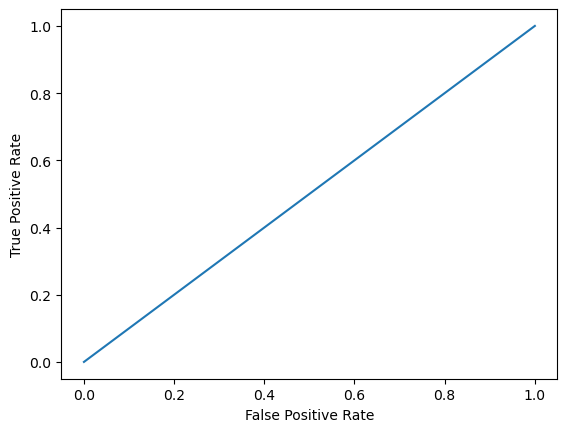

AUC score: 0.5


In [76]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [77]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)